<a href="https://colab.research.google.com/github/fabriciocarraro/NLP-exploration_Sentiment-analysis-Disaster_prediction/blob/main/NLP_exploration_Sentiment_analysis_Disaster_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Uninstall any existing PyTorch packages
!pip uninstall -y -q torch torchaudio torchvision

In [2]:
!pip install -q torch==2.0.1+cu118 torchvision==0.15.2+cu118 torchtext==0.15.2 -f https://download.pytorch.org/whl/torch_stable.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 873.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 8.6 MB/s eta 0:00:00


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from typing import Tuple
import time

In [44]:
SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [45]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [46]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [47]:
train_df.isnull().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


In [48]:
train_df = train_df[['text', 'target']]
train_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [49]:
print(train_df['target'].value_counts())

target
0    4342
1    3271
Name: count, dtype: int64


# Bag-of-Words with Logistic Regression

In [50]:
def bow(model, dataset, reviews_column, classification_column):
  vectorizer = CountVectorizer(max_features=50)
  bag_of_words = vectorizer.fit_transform(dataset[reviews_column])


  X_train, X_test, y_train, y_test = train_test_split(bag_of_words,
                                                      dataset[classification_column],
                                                      random_state=SEED,
                                                      stratify=dataset[classification_column])


  model.fit(X_train, y_train)
  score = model.score(X_test, y_test)
  print(f'{score*100:.2f}%')

In [51]:
model_log_reg = LogisticRegression()
bow(model_log_reg, train_df, 'text', 'target')

68.22%


In [52]:
import spacy

spacy.prefer_gpu()
print("Using GPU:", spacy.prefer_gpu())

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    text = text.lower()

    doc = nlp(text)

    cleaned_tokens = [
        token.lemma_ for token in doc
        if not token.is_punct            # Remove punctuation
        and not token.is_space           # Remove whitespaces
        and not token.is_stop            # Remove stop words
        and not token.like_url           # Remove URLs
        and not token.like_email         # Remove emails
        and token.is_alpha               # Remove non-alphabetic tokens
        and len(token.text) > 2          # Remove short words
    ]

    cleaned_text = " ".join(cleaned_tokens)
    return cleaned_text

Using GPU: True


In [53]:
treated_phrases = list()
for review in train_df['text']:
    new_phrase = preprocess_text(review)
    treated_phrases.append(new_phrase)

train_df.loc[:, 'treated_text'] = treated_phrases
train_df

,text,target,treated_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,1,get send photo ruby alaska smoke wildfire pour...
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,giant crane hold bridge collapse nearby home
7609,@aria_ahrary @TheTawniest The out of control w...,1,control wild fire california northern state tr...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,volcano hawaii
7611,Police investigating after an e-bike collided ...,1,police investigate bike collide car little por...


In [54]:
train_df['treated_text_length'] = train_df['treated_text'].fillna('').apply(len)
print(train_df['treated_text_length'].min())

0


In [55]:
train_df_cleaned = train_df[train_df['treated_text_length'] > 0].reset_index(drop=True)
print(train_df_cleaned['treated_text_length'].min())

3


In [56]:
model_log_reg = LogisticRegression()
bow(model_log_reg, train_df_cleaned, 'treated_text', 'target')

69.56%


# Bag-of-Words with XGBoost

In [57]:
model_xgboost = XGBClassifier()
bow(model_xgboost, train_df_cleaned, 'treated_text', 'target')

70.19%


# TF-IDF with Logistic Regression

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(model, dataset, reviews_column, classification_column):
    tfidf = TfidfVectorizer(max_features=50)
    tfidf_data = tfidf.fit_transform(dataset[reviews_column])

    X_train, X_test, y_train, y_test = train_test_split(tfidf_data,
                                                        dataset[classification_column],
                                                        random_state=SEED,
                                                        stratify=dataset[classification_column])

    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print(f'{score*100:.2f}%')

In [59]:
model_log_reg = LogisticRegression()
print('Untreated data')
tfidf(model_log_reg, train_df_cleaned, 'text', 'target')
print('Treated data')
tfidf(model_log_reg, train_df_cleaned, 'treated_text', 'target')

Untreated data
67.67%
Treated data
69.09%


# TF-IDF with XGBoost

In [60]:
model_xgboost = XGBClassifier()
tfidf(model_xgboost, train_df_cleaned, 'treated_text', 'target')

68.35%


# RNNs (GRU & LSTM) with GloVe

In [61]:
treated_train_df = train_df_cleaned[['target', 'treated_text']]
treated_train_df

,target,treated_text
0,1,deed reason earthquake allah forgive
1,1,forest fire near ronge sask canada
2,1,resident ask shelter place notify officer evac...
3,1,people receive wildfire evacuation order calif...
4,1,get send photo ruby alaska smoke wildfire pour...
...,...,...
7600,1,giant crane hold bridge collapse nearby home
7601,1,control wild fire california northern state tr...
7602,1,volcano hawaii
7603,1,police investigate bike collide car little por...


In [62]:
len(treated_train_df['treated_text'])

7605

In [63]:
spacy.prefer_gpu()
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [64]:
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

MAX_VOCAB_SIZE = 25_000

vocab = build_vocab_from_iterator(
    yield_tokens(treated_train_df['treated_text']),
    max_tokens=MAX_VOCAB_SIZE,
    specials=['<unk>', '<pad>']
)

vocab.set_default_index(vocab['<unk>'])

**yield_tokens()** inside **build_vocab_from_iterator()**:

The common pattern of using a generator (with yield) is the Pythonic way and best approach to handle large datasets where you don't want to store all tokenized data in memory at once, but one could just as well pass a list of already-tokenized texts in one go (like a list of lists).

In [65]:
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []

    for (_label, _text) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(vocab(tokenizer(_text)), dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(len(processed_text))

    return (torch.tensor(label_list, dtype=torch.int64).to(device),
            nn.utils.rnn.pad_sequence(text_list, batch_first=True).to(device),
            torch.tensor(lengths, dtype=torch.int64).to(device))

**nn.utils.rnn.pad_sequence()**

When dealing with sequences of varying lengths, you need to ensure that all sequences in a given batch have a uniform shape before passing them into an RNN or other sequential models. Each text example can have a different number of tokens (e.g., one sentence could be 5 tokens, another 12 tokens). PyTorch's RNN modules need all sequences in a batch to be of the same length when you feed them in a single tensor.
"pad_sequence" automatically pads shorter sequences in the batch so they match the length of the longest sequence.

Also, **pad_sequence()** already returns a PyTorch tensor.

-----

**length**

In the RNN training pipeline, the model needs to know where the actual tokens end and where padding begins. By passing in the lengths of each sequence, PyTorch's RNN can skip padding positions and focus only on valid (non-padded) tokens. This avoids wasting computation on padding tokens, speeds up training, and can improve gradient flow for variable-length sequences.


In [66]:
BATCH_SIZE = 64

X_train, X_test, y_train, y_test = train_test_split(treated_train_df['treated_text'],
                                                    treated_train_df['target'],
                                                    random_state=SEED,
                                                    stratify=treated_train_df['target'])

train_dataset = [(y, x) for x, y in zip(X_train, y_train)]
test_dataset = [(y, x) for x, y in zip(X_test, y_test)]

train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=collate_batch)

test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             collate_fn=collate_batch)

When one passes **collate_fn** to DataLoader, it applies this function (in our case, "collate_batch()") to every batch, handling the padding, creating tensors, and moving them to the right device (GPU). Without it, the default collation would likely fail or not handle padding for variable-length sequences correctly.

In [67]:
vectors = GloVe(name='6B', dim=100)

In [83]:
class RNN_GRU(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, pad_idx):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
    self.rnn = nn.GRU(embedding_dim, hidden_size, num_layers=2, dropout=0.2, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(hidden_size * 2, output_size)

    self.embedding.weight.data.copy_(vectors.get_vecs_by_tokens(vocab.get_itos()))
    self.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

  def forward(self, text, lengths):
    embedded = self.embedding(text)
    packed_embedded = pack_padded_sequence(embedded,
                                           lengths.cpu(),
                                           batch_first=True,
                                           enforce_sorted=False)

    packed_output, _ = self.rnn(packed_embedded)
    output, _ = pad_packed_sequence(packed_output, batch_first=True)
    output = F.adaptive_max_pool1d(output.transpose(1, 2), 1).squeeze(dim=-1)
    return self.fc(output)

When you feed integer IDs (coming from your vocabulary) into **nn.Embedding**, it returns a corresponding dense vector of size **embedding_dim**. For example, if embedding_dim=100, then each token index turns into a 100-dimensional vector.

The embedding layer maintains a matrix of shape (vocab_size, embedding_dim). Each row corresponds to a specific token's embedding vector, and these vectors get updated during training via backpropagation to capture semantic or syntactic relationships among tokens.

---

**pack_padded_sequence** is converts a batch of padded sequences into a packed representation. Packed sequences let PyTorch's RNN modules skip the padded tokens during processing and focus only on the valid (non-padded) parts of each sequence. The output of **pack_padded_sequence()** is a special "PackedSequence" object that is then fed to the RNN.



In [84]:
class RNN_GRU_withAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.GRU(embedding_dim, hidden_size, num_layers=2, dropout=0.2, batch_first=True, bidirectional=True)
        # Attention mechanism - a simple feedforward layer that outputs an "energy" score
        # for each time step. Then we'll take a softmax to get the attention weights.
        self.attn = nn.Linear(hidden_size * 2, 1)  # because bidirectional => hidden_size*2
        self.fc = nn.Linear(hidden_size * 2, output_size)

        self.embedding.weight.data.copy_(vectors.get_vecs_by_tokens(vocab.get_itos()))
        self.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded,
                                            lengths.cpu(),
                                            batch_first=True,
                                            enforce_sorted=False)

        packed_output, _ = self.rnn(packed_embedded)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        # Attention scores - transform each hidden state to a single "energy" value
        attn_energies = self.attn(output)
        # Convert energies to attention weights via softmax along time dimension
        attn_weights = F.softmax(attn_energies.squeeze(-1), dim=1)

        # Weighted sum of hidden states to get a single context vector
        context = torch.bmm(
            attn_weights.unsqueeze(1),  # (batch_size, 1, seq_len)
            output                      # (batch_size, seq_len, hidden_size*2)
        ).squeeze(1)                     # => (batch_size, hidden_size*2)

        return self.fc(context)

In [97]:
class RNN_LSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, pad_idx):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
    self.rnn = nn.LSTM(embedding_dim, hidden_size, num_layers=2, dropout=0.2, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(hidden_size * 2, output_size)

    self.embedding.weight.data.copy_(vectors.get_vecs_by_tokens(vocab.get_itos()))
    self.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

  def forward(self, text, lengths):
    embedded = self.embedding(text)
    packed_embedded = pack_padded_sequence(embedded,
                                           lengths.cpu(),
                                           batch_first=True,
                                           enforce_sorted=False)

    packed_output, _ = self.rnn(packed_embedded)
    output, _ = pad_packed_sequence(packed_output, batch_first=True)
    output = F.adaptive_max_pool1d(output.transpose(1, 2), 1).squeeze(dim=-1)
    return self.fc(output)

In [86]:
class RNN_LSTM_withAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM(embedding_dim, hidden_size, num_layers=2, dropout=0.2, batch_first=True, bidirectional=True)
        # Attention mechanism - a simple feedforward layer that outputs an "energy" score
        # for each time step. Then we'll take a softmax to get the attention weights.
        self.attn = nn.Linear(hidden_size * 2, 1)  # because bidirectional => hidden_size*2
        self.fc = nn.Linear(hidden_size * 2, output_size)

        self.embedding.weight.data.copy_(vectors.get_vecs_by_tokens(vocab.get_itos()))
        self.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded,
                                            lengths.cpu(),
                                            batch_first=True,
                                            enforce_sorted=False)

        packed_output, _ = self.rnn(packed_embedded)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        # Attention scores - transform each hidden state to a single "energy" value
        attn_energies = self.attn(output)
        # Convert energies to attention weights via softmax along time dimension
        attn_weights = F.softmax(attn_energies.squeeze(-1), dim=1)

        # Weighted sum of hidden states to get a single context vector
        context = torch.bmm(
            attn_weights.unsqueeze(1),  # (batch_size, 1, seq_len)
            output                      # (batch_size, seq_len, hidden_size*2)
        ).squeeze(1)                     # => (batch_size, hidden_size*2)

        return self.fc(context)

In [87]:
def train_epoch(model, dataloader, model_optimizer, criterion):
    model.train()
    total_loss = total_acc = total_count = batch_count = 0
    start = time.time()

    for labels, text, lengths in dataloader:
        model_optimizer.zero_grad()
        predictions = model(text, lengths)
        loss = criterion(predictions, labels)

        loss.backward()
        model_optimizer.step()

        total_loss += loss.item()
        total_acc += (predictions.argmax(dim=1) == labels).sum().item()
        total_count += labels.size(0)
        batch_count += 1

    train_loss = total_loss / batch_count
    train_acc = total_acc / total_count

    end = time.time()

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Time: {end-start:.2f}s")

    return train_loss, train_acc


def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = total_acc = total_count = batch_count = 0
    start = time.time()

    with torch.no_grad():
        for labels, text, lengths in dataloader:
            predictions = model(text, lengths)
            loss = criterion(predictions, labels)

            total_loss += loss.item()
            total_acc += (predictions.argmax(dim=1) == labels).sum().item()
            total_count += labels.size(0)
            batch_count += 1

    valid_loss = total_loss / batch_count
    valid_acc = total_acc / total_count

    end = time.time()
    print(f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc*100:.2f}% | Time: {end-start:.2f}s")

    return valid_loss, valid_acc

In [88]:
def run_model(model, model_optimizer, nn_type):
    N_EPOCHS = 50
    best_val_acc = 0.0

    train_losses, valid_losses, train_accus, valid_accus = [], [], [], []

    for epoch in range(N_EPOCHS):
        print(f"Epoch: {epoch+1:02d}")

        train_loss, train_acc = train_epoch(model, train_dataloader, model_optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, test_dataloader, criterion)

        # Compare valid_acc with best_val_acc
        if valid_acc > best_val_acc:
            best_val_acc = valid_acc
            # Save the model's state_dict
            torch.save(model.state_dict(), f"best_model_{nn_type}.pt")

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accus.append(train_acc)
        valid_accus.append(valid_acc)

    print(f"\nThe best {nn_type.upper()} model was had an accuracy of {best_val_acc * 100:.2f}%")

    return N_EPOCHS, train_losses, valid_losses, train_accus, valid_accus

In [89]:
def plot_curves(N_EPOCHS, train_losses, valid_losses, train_accus, valid_accus):
    # Plot Loss Curves
    plt.figure(figsize=(6,3))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Test Loss')
    plt.xticks(range(0, N_EPOCHS, 5))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy Curves
    plt.figure(figsize=(6,3))
    plt.plot(train_accus, label='Train Accuracy')
    plt.plot(valid_accus, label='Test Accuracy')
    plt.xticks(range(0, N_EPOCHS, 5))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{val * 100:.0f}%"))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## GRU

In [117]:
model_gru = RNN_GRU(len(vocab), 100, 256, 2, vocab['<pad>']).to(device)
model_gru_with_attention = RNN_GRU_withAttention(len(vocab), 100, 256, 2, vocab['<pad>']).to(device)

criterion = nn.CrossEntropyLoss().to(device)

optimizer_gru = optim.Adam(model_gru.parameters(), lr=1e-4, weight_decay=5e-5)
optimizer_gru_with_attention = optim.Adam(model_gru_with_attention.parameters(), lr=1e-4, weight_decay=5e-5)

print(model_gru)
print("-----"*5)
print(model_gru_with_attention)

RNN_GRU(
  (embedding): Embedding(11085, 100, padding_idx=1)
  (rnn): GRU(100, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=2, bias=True)
)
-------------------------
RNN_GRU_withAttention(
  (embedding): Embedding(11085, 100, padding_idx=1)
  (rnn): GRU(100, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (attn): Linear(in_features=512, out_features=1, bias=True)
  (fc): Linear(in_features=512, out_features=2, bias=True)
)


In [91]:
results_gru = []
results_gru = run_model(model_gru, optimizer_gru, "gru")

Epoch: 01
Train Loss: 0.5661 | Train Acc: 74.80% | Time: 1.03s
Valid Loss: 0.4676 | Valid Acc: 78.55% | Time: 0.17s
Epoch: 02
Train Loss: 0.4662 | Train Acc: 78.84% | Time: 1.00s
Valid Loss: 0.4505 | Valid Acc: 79.28% | Time: 0.15s
Epoch: 03
Train Loss: 0.4437 | Train Acc: 79.94% | Time: 0.97s
Valid Loss: 0.4404 | Valid Acc: 79.55% | Time: 0.17s
Epoch: 04
Train Loss: 0.4310 | Train Acc: 80.82% | Time: 1.02s
Valid Loss: 0.4369 | Valid Acc: 80.18% | Time: 0.16s
Epoch: 05
Train Loss: 0.4208 | Train Acc: 81.50% | Time: 1.01s
Valid Loss: 0.4327 | Valid Acc: 80.49% | Time: 0.15s
Epoch: 06
Train Loss: 0.4141 | Train Acc: 82.40% | Time: 0.96s
Valid Loss: 0.4294 | Valid Acc: 80.23% | Time: 0.15s
Epoch: 07
Train Loss: 0.3994 | Train Acc: 83.18% | Time: 0.97s
Valid Loss: 0.4292 | Valid Acc: 80.55% | Time: 0.15s
Epoch: 08
Train Loss: 0.3938 | Train Acc: 83.32% | Time: 0.97s
Valid Loss: 0.4295 | Valid Acc: 80.39% | Time: 0.15s
Epoch: 09
Train Loss: 0.3739 | Train Acc: 84.18% | Time: 0.97s
Valid Los

RNN - GRU


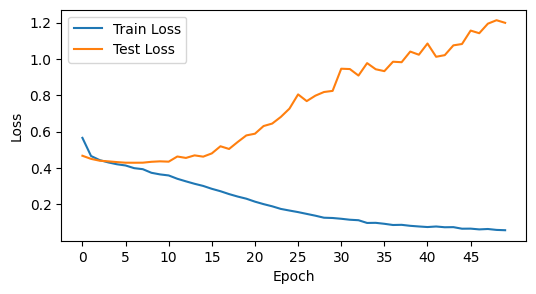

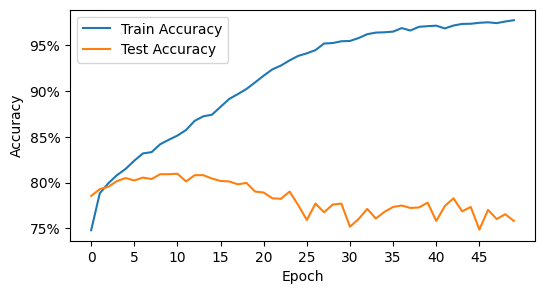

In [92]:
print('RNN - GRU')
plot_curves(results_gru[0], results_gru[1], results_gru[2], results_gru[3], results_gru[4])

In [93]:
results_gru_with_attention = []
results_gru_with_attention = run_model(model_gru_with_attention, optimizer_gru_with_attention, "gru_with_attention")

Epoch: 01
Train Loss: 0.5739 | Train Acc: 74.15% | Time: 1.11s
Valid Loss: 0.4758 | Valid Acc: 79.13% | Time: 0.16s
Epoch: 02
Train Loss: 0.4725 | Train Acc: 78.34% | Time: 1.06s
Valid Loss: 0.4590 | Valid Acc: 79.65% | Time: 0.16s
Epoch: 03
Train Loss: 0.4515 | Train Acc: 80.08% | Time: 1.04s
Valid Loss: 0.4519 | Valid Acc: 79.07% | Time: 0.16s
Epoch: 04
Train Loss: 0.4400 | Train Acc: 80.33% | Time: 1.04s
Valid Loss: 0.4450 | Valid Acc: 79.44% | Time: 0.16s
Epoch: 05
Train Loss: 0.4248 | Train Acc: 80.71% | Time: 1.03s
Valid Loss: 0.4469 | Valid Acc: 80.07% | Time: 0.16s
Epoch: 06
Train Loss: 0.4127 | Train Acc: 81.73% | Time: 1.02s
Valid Loss: 0.4386 | Valid Acc: 80.13% | Time: 0.16s
Epoch: 07
Train Loss: 0.3994 | Train Acc: 82.69% | Time: 1.07s
Valid Loss: 0.4400 | Valid Acc: 80.49% | Time: 0.16s
Epoch: 08
Train Loss: 0.3919 | Train Acc: 83.08% | Time: 1.09s
Valid Loss: 0.4469 | Valid Acc: 80.07% | Time: 0.16s
Epoch: 09
Train Loss: 0.3825 | Train Acc: 83.62% | Time: 1.07s
Valid Los

RNN - GRU with Attention


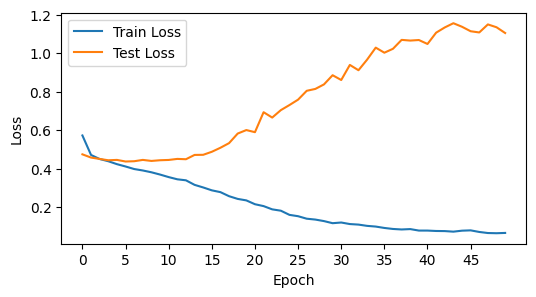

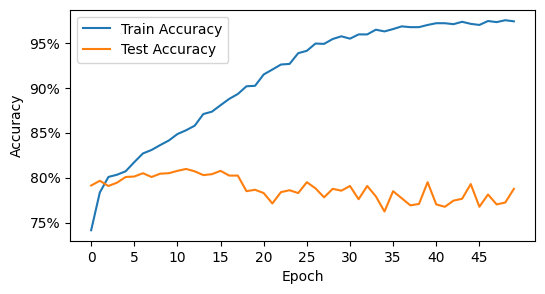

In [94]:
print('RNN - GRU with Attention')
plot_curves(results_gru_with_attention[0], results_gru_with_attention[1], results_gru_with_attention[2],
            results_gru_with_attention[3], results_gru_with_attention[4])

## LSTM

In [99]:
model_lstm = RNN_LSTM(len(vocab), 100, 256, 2, vocab['<pad>']).to(device)
model_lstm_with_attention = RNN_LSTM_withAttention(len(vocab), 100, 256, 2, vocab['<pad>']).to(device)

criterion = nn.CrossEntropyLoss().to(device)

optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=1e-4, weight_decay=5e-5)
optimizer_lstm_with_attention = optim.Adam(model_lstm_with_attention.parameters(), lr=1e-4, weight_decay=5e-5)

print(model_lstm)
print("-----"*5)
print(model_lstm_with_attention)

RNN_LSTM(
  (embedding): Embedding(11085, 100, padding_idx=1)
  (rnn): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=2, bias=True)
)
-------------------------
RNN_LSTM_withAttention(
  (embedding): Embedding(11085, 100, padding_idx=1)
  (rnn): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (attn): Linear(in_features=512, out_features=1, bias=True)
  (fc): Linear(in_features=512, out_features=2, bias=True)
)


In [100]:
results_lstm = []
results_lstm = run_model(model_lstm, optimizer_lstm, "lstm")

Epoch: 01
Train Loss: 0.6080 | Train Acc: 73.96% | Time: 1.09s
Valid Loss: 0.4832 | Valid Acc: 79.18% | Time: 0.16s
Epoch: 02
Train Loss: 0.4784 | Train Acc: 79.05% | Time: 1.02s
Valid Loss: 0.4549 | Valid Acc: 79.55% | Time: 0.16s
Epoch: 03
Train Loss: 0.4488 | Train Acc: 79.85% | Time: 1.03s
Valid Loss: 0.4433 | Valid Acc: 79.50% | Time: 0.16s
Epoch: 04
Train Loss: 0.4351 | Train Acc: 80.85% | Time: 1.01s
Valid Loss: 0.4435 | Valid Acc: 79.76% | Time: 0.16s
Epoch: 05
Train Loss: 0.4233 | Train Acc: 81.31% | Time: 1.03s
Valid Loss: 0.4327 | Valid Acc: 80.39% | Time: 0.16s
Epoch: 06
Train Loss: 0.4098 | Train Acc: 82.24% | Time: 1.06s
Valid Loss: 0.4312 | Valid Acc: 80.60% | Time: 0.16s
Epoch: 07
Train Loss: 0.4035 | Train Acc: 83.03% | Time: 1.05s
Valid Loss: 0.4281 | Valid Acc: 80.81% | Time: 0.16s
Epoch: 08
Train Loss: 0.3944 | Train Acc: 83.34% | Time: 1.04s
Valid Loss: 0.4287 | Valid Acc: 80.81% | Time: 0.16s
Epoch: 09
Train Loss: 0.3795 | Train Acc: 84.03% | Time: 1.06s
Valid Los

RNN - LSTM


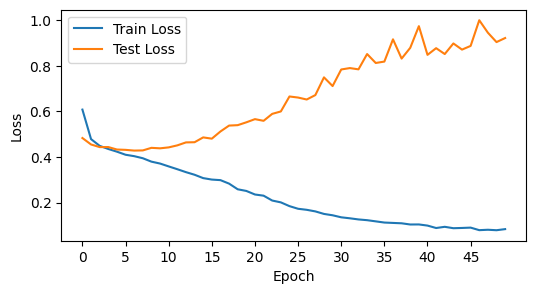

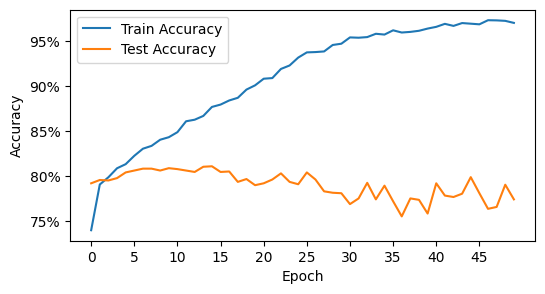

In [101]:
print('RNN - LSTM')
plot_curves(results_lstm[0], results_lstm[1], results_lstm[2], results_lstm[3], results_lstm[4])

In [102]:
results_lstm_with_attention = []
results_lstm_with_attention = run_model(model_lstm_with_attention, optimizer_lstm_with_attention, "lstm_with_attention")

Epoch: 01
Train Loss: 0.6182 | Train Acc: 70.38% | Time: 1.02s
Valid Loss: 0.5174 | Valid Acc: 77.39% | Time: 0.16s
Epoch: 02
Train Loss: 0.5043 | Train Acc: 77.99% | Time: 1.00s
Valid Loss: 0.4833 | Valid Acc: 79.39% | Time: 0.16s
Epoch: 03
Train Loss: 0.4781 | Train Acc: 78.96% | Time: 1.02s
Valid Loss: 0.4672 | Valid Acc: 78.97% | Time: 0.16s
Epoch: 04
Train Loss: 0.4613 | Train Acc: 80.31% | Time: 1.01s
Valid Loss: 0.4565 | Valid Acc: 79.65% | Time: 0.16s
Epoch: 05
Train Loss: 0.4393 | Train Acc: 81.05% | Time: 1.03s
Valid Loss: 0.4520 | Valid Acc: 79.92% | Time: 0.20s
Epoch: 06
Train Loss: 0.4270 | Train Acc: 81.41% | Time: 1.04s
Valid Loss: 0.4461 | Valid Acc: 79.92% | Time: 0.16s
Epoch: 07
Train Loss: 0.4139 | Train Acc: 82.11% | Time: 1.03s
Valid Loss: 0.4435 | Valid Acc: 79.81% | Time: 0.18s
Epoch: 08
Train Loss: 0.4040 | Train Acc: 82.34% | Time: 1.02s
Valid Loss: 0.4382 | Valid Acc: 79.92% | Time: 0.16s
Epoch: 09
Train Loss: 0.3898 | Train Acc: 83.06% | Time: 1.04s
Valid Los

RNN - LSTM with Attention


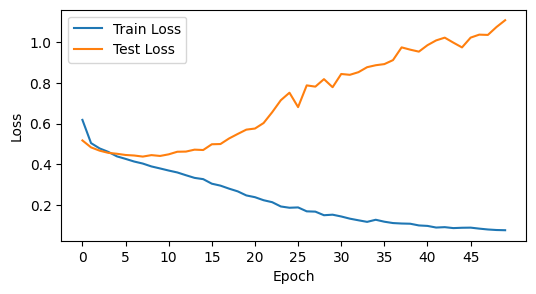

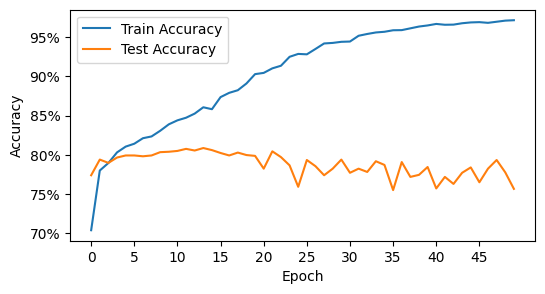

In [103]:
print('RNN - LSTM with Attention')
plot_curves(results_lstm_with_attention[0], results_lstm_with_attention[1], results_lstm_with_attention[2],
            results_lstm_with_attention[3], results_lstm_with_attention[4])

# Transformers (RoBERTa & DistilBERT)

In [104]:
from transformers import (
    RobertaTokenizer, RobertaModel,
    DistilBertTokenizer, DistilBertModel,
    AdamW, get_linear_schedule_with_warmup
)
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [118]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [119]:
class TransformerClassifier(nn.Module):
    def __init__(self, transformer_model, n_classes):
        super().__init__()
        self.transformer = transformer_model
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use [CLS] token
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

In [120]:
def train_model(model, train_loader, val_loader, device, nn_type, num_epochs):
    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()

    # Calculate total training steps for scheduler
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    train_losses, valid_losses, train_accus, valid_accus = [], [], [], []
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')

        # Training phase
        start_train = time.time()
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0

        for batch in tqdm(train_loader, desc='Training'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = train_correct / train_total
        end_train = time.time()

        # Validation phase
        start_eval = time.time()
        model.eval()
        total_val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total
        end_eval = time.time()

        # Store losses and accuracies for later plotting
        train_losses.append(total_train_loss/len(train_loader))
        valid_losses.append(total_val_loss/len(val_loader))
        train_accus.append(train_accuracy)
        valid_accus.append(val_accuracy)

        # Compare valid_acc with best_val_acc
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            # Save the model's state_dict
            torch.save(model.state_dict(), f"best_model_{nn_type}.pt")

        print(f"Train Loss: {total_train_loss/len(train_loader):.4f} | Train Acc: {train_accuracy * 100:.2f}% | Time: {end_train-start_train:.2f}s")
        print(f"Valid Loss: {total_val_loss/len(val_loader):.4f} | Valid Acc: {val_accuracy * 100:.2f}% | Time: {end_eval-start_eval:.2f}s")

    print(f"\nThe best {nn_type.upper()} model was had an accuracy of {best_val_acc * 100:.2f}%")

    return num_epochs, train_losses, valid_losses, train_accus, valid_accus

## RoBERTa

In [121]:
def setup_roberta(train_df, batch_size=16):
    # Initialize tokenizer and model
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    transformer = RobertaModel.from_pretrained('roberta-base')

    # Split data
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_df['treated_text'].values,
        train_df['target'].values,
        test_size=0.2,
        random_state=SEED
    )

    # Create datasets
    train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer)
    val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model
    model = TransformerClassifier(transformer, n_classes=2)

    return model, train_loader, val_loader

In [122]:
def train_roberta(train_df):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Setup model and data
    model, train_loader, val_loader = setup_roberta(train_df)
    model = model.to(device)

    # Train the model
    return train_model(model, train_loader, val_loader, device, 'roberta', num_epochs=15)

In [123]:
results_roberta = []
results_roberta = train_roberta(treated_train_df)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/15


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.5089 | Train Acc: 77.12% | Time: 65.66s
Valid Loss: 0.4140 | Valid Acc: 81.85% | Time: 5.22s

Epoch 2/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.4042 | Train Acc: 83.78% | Time: 66.88s
Valid Loss: 0.4210 | Valid Acc: 82.12% | Time: 5.33s

Epoch 3/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.3522 | Train Acc: 86.47% | Time: 68.27s
Valid Loss: 0.4332 | Valid Acc: 82.91% | Time: 5.44s

Epoch 4/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.2867 | Train Acc: 89.53% | Time: 68.49s
Valid Loss: 0.5032 | Valid Acc: 81.59% | Time: 5.44s

Epoch 5/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.2336 | Train Acc: 91.86% | Time: 68.43s
Valid Loss: 0.6295 | Valid Acc: 80.41% | Time: 5.43s

Epoch 6/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.2054 | Train Acc: 93.36% | Time: 68.43s
Valid Loss: 0.7693 | Valid Acc: 81.00% | Time: 5.45s

Epoch 7/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.1799 | Train Acc: 94.76% | Time: 68.37s
Valid Loss: 0.8708 | Valid Acc: 79.36% | Time: 5.46s

Epoch 8/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.1527 | Train Acc: 95.58% | Time: 68.37s
Valid Loss: 1.1076 | Valid Acc: 80.41% | Time: 5.46s

Epoch 9/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.1375 | Train Acc: 96.30% | Time: 68.43s
Valid Loss: 1.1517 | Valid Acc: 80.47% | Time: 5.45s

Epoch 10/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.1154 | Train Acc: 96.99% | Time: 68.45s
Valid Loss: 1.1401 | Valid Acc: 80.47% | Time: 5.41s

Epoch 11/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.0974 | Train Acc: 97.53% | Time: 68.48s
Valid Loss: 1.3920 | Valid Acc: 79.29% | Time: 5.43s

Epoch 12/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.1012 | Train Acc: 97.39% | Time: 68.47s
Valid Loss: 1.4356 | Valid Acc: 79.62% | Time: 5.44s

Epoch 13/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.0867 | Train Acc: 97.73% | Time: 68.47s
Valid Loss: 1.4383 | Valid Acc: 81.26% | Time: 5.45s

Epoch 14/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.0829 | Train Acc: 97.85% | Time: 68.47s
Valid Loss: 1.4390 | Valid Acc: 79.82% | Time: 5.44s

Epoch 15/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.0777 | Train Acc: 98.08% | Time: 68.43s
Valid Loss: 1.5121 | Valid Acc: 79.42% | Time: 5.44s

The best ROBERTA model was had an accuracy of 82.91%


Transformers - RoBERTa


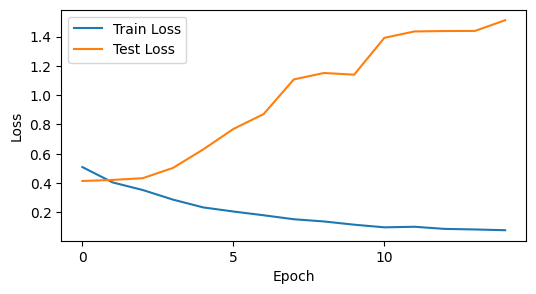

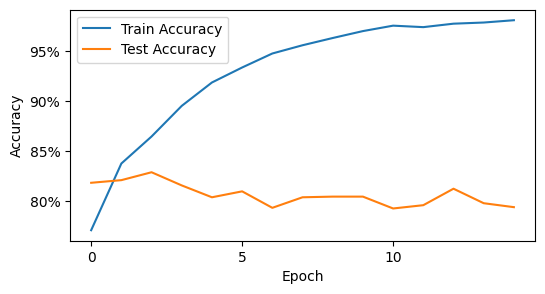

In [124]:
print('Transformers - RoBERTa')
plot_curves(results_roberta[0], results_roberta[1], results_roberta[2],
            results_roberta[3], results_roberta[4])

## DistilBERT

In [125]:
def setup_distilbert(train_df, batch_size=16):
    # Initialize tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    transformer = DistilBertModel.from_pretrained('distilbert-base-uncased')

    # Split data
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_df['treated_text'].values,
        train_df['target'].values,
        test_size=0.2,
        random_state=SEED
    )

    # Create datasets
    train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer)
    val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model
    model = TransformerClassifier(transformer, n_classes=2)

    return model, train_loader, val_loader

In [126]:
def train_distilbert(train_df):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Setup model and data
    model, train_loader, val_loader = setup_distilbert(train_df)
    model = model.to(device)

    # Train the model
    return train_model(model, train_loader, val_loader, device, "distilbert", num_epochs=15)

In [127]:
results_distilbert = []
results_distilbert = train_distilbert(treated_train_df)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


Epoch 1/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.4810 | Train Acc: 78.45% | Time: 34.93s
Valid Loss: 0.3971 | Valid Acc: 81.92% | Time: 3.03s

Epoch 2/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.3625 | Train Acc: 85.42% | Time: 34.80s
Valid Loss: 0.4023 | Valid Acc: 83.37% | Time: 3.03s

Epoch 3/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.2839 | Train Acc: 89.63% | Time: 34.95s
Valid Loss: 0.5078 | Valid Acc: 81.92% | Time: 3.07s

Epoch 4/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.2110 | Train Acc: 92.44% | Time: 34.93s
Valid Loss: 0.6067 | Valid Acc: 81.20% | Time: 3.06s

Epoch 5/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.1633 | Train Acc: 94.66% | Time: 34.87s
Valid Loss: 0.7806 | Valid Acc: 80.14% | Time: 3.05s

Epoch 6/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.1179 | Train Acc: 96.30% | Time: 34.99s
Valid Loss: 1.1596 | Valid Acc: 79.49% | Time: 3.05s

Epoch 7/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.1070 | Train Acc: 96.81% | Time: 34.97s
Valid Loss: 1.0662 | Valid Acc: 81.07% | Time: 3.06s

Epoch 8/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.0851 | Train Acc: 97.37% | Time: 34.92s
Valid Loss: 1.1382 | Valid Acc: 80.21% | Time: 3.08s

Epoch 9/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.0741 | Train Acc: 97.68% | Time: 34.96s
Valid Loss: 1.1312 | Valid Acc: 80.74% | Time: 3.06s

Epoch 10/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.0687 | Train Acc: 97.72% | Time: 34.92s
Valid Loss: 1.1479 | Valid Acc: 81.33% | Time: 3.05s

Epoch 11/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.0594 | Train Acc: 98.08% | Time: 34.92s
Valid Loss: 1.1824 | Valid Acc: 80.01% | Time: 3.07s

Epoch 12/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.0535 | Train Acc: 98.09% | Time: 34.90s
Valid Loss: 1.2723 | Valid Acc: 81.07% | Time: 3.07s

Epoch 13/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.0521 | Train Acc: 98.18% | Time: 34.99s
Valid Loss: 1.3128 | Valid Acc: 80.60% | Time: 3.07s

Epoch 14/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.0451 | Train Acc: 98.24% | Time: 34.97s
Valid Loss: 1.3130 | Valid Acc: 81.07% | Time: 3.07s

Epoch 15/15


Training:   0%|          | 0/381 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Train Loss: 0.0426 | Train Acc: 98.42% | Time: 34.97s
Valid Loss: 1.3222 | Valid Acc: 81.07% | Time: 3.05s

The best DISTILBERT model was had an accuracy of 83.37%


Transformers - DistilBERT


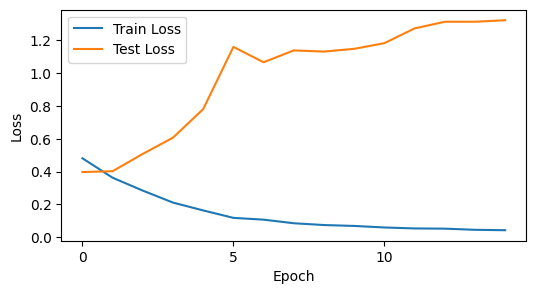

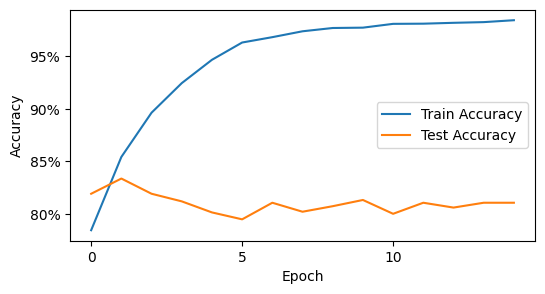

In [128]:
print('Transformers - DistilBERT')
plot_curves(results_distilbert[0], results_distilbert[1], results_distilbert[2],
            results_distilbert[3], results_distilbert[4])